In [1]:
from pathlib import Path
import jax.numpy as jnp
import jax
import sys
sys.path.append('../')
from read_data import load_datasets
from jaxpm.painting import compensate_cic
import yaml
from read_model import read_model
from jax.experimental.ode import odeint
from jaxpm.pm import make_ode_fn
import jax_cosmo as jc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from jaxpm.pm import get_delta
from jaxpm.utils import power_spectrum, cross_correlation_coefficients
import numpy as np
from loss import get_mse_pos
plt.style.use(['science', 'vibrant'])

In [2]:
# add option for time adding-diffusion like
# check feature maps and potential plots, highlight density dependence
# run halo finder -> train on 128^3 at least for 256 Mpc box?
# why is memory exploiding as function of nsims? it should only be loaded once
# hyper opt with wand
# think of model validations: run on bigger volume same resolution

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
run_name = 'sleek-haze-211' #'lively-firebrand-188' #'olive-star-167' 
if run_name == 'trim-moon-187':
    step = 60
if run_name == 'rare-wood-189':
    step = 260
else:
    step = None
model_dir = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/models/{run_name}')

In [5]:
with open(model_dir / 'config.yaml') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)['data']
mesh_lr = data_config['mesh_lr']
mesh_hr = data_config['mesh_hr']
box_size = data_config['box_size']
n_snapshots = data_config['n_snapshots']

In [6]:
data_dir = Path(f"/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/data/matched_{mesh_lr}_{mesh_hr}_L{box_size:.1f}_S{n_snapshots}/")
omega_c = 0.25
sigma8 = 0.8
cosmology = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

scale_factors = jnp.load(data_dir / f"scale_factors.npy")
snapshots = None
if snapshots is not None:
    scale_factors = scale_factors[snapshots]

_, val_data = load_datasets(
        1,
        1,
        mesh_hr=mesh_hr,
        mesh_lr=mesh_lr,
        data_dir=data_dir,
        snapshots=snapshots,
        box_size=box_size,
    )
data = val_data[0]

I0000 00:00:1695651594.476315  787908 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [7]:


with open(model_dir / 'config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)['correction_model']

neural_net, params = read_model(
    model_dir,
    step=step,
)

In [8]:
@jax.jit
def get_prediction(
    params,
    pos_lr, 
    vel_lr,
    scale_factors,
):
    pos_pm, vel_pm = odeint(
        make_ode_fn(mesh_shape=(mesh_lr,mesh_lr,mesh_lr), 
                    add_correction=config['type'], 
                    model=neural_net),
        [pos_lr[0], vel_lr[0]],
        scale_factors,
        cosmology,
        params,
        rtol=1e-5,
        atol=1e-5,
    )
    return pos_pm, vel_pm



In [9]:
import jax
print(jax.devices())

[gpu(id=0)]


In [10]:
pos_pred, vel_pred = get_prediction(
    params,
    data['lr'].positions * mesh_lr,
    data['lr'].velocities * mesh_lr,
    scale_factors,

)
pos_hr = (data['hr'].positions * mesh_lr) % mesh_lr
pos_pred = pos_pred % mesh_lr

In [11]:
pos_lr_test = (data['lr'].positions * mesh_lr) % mesh_lr

In [12]:
mse_scale = [get_mse_pos(pos_hr[i], pos_lr_test[i]) for i in range(len(pos_pred))]

In [13]:
np.array(mse_scale)/scale_factors**1.5

Array([0.26073846, 0.3401655 , 0.39317653, 0.42376482, 0.41532344,
       0.3797627 , 0.33576277, 0.2933485 , 0.25607795, 0.22452343],      dtype=float32)

In [14]:
pos_pred /= mesh_lr

Text(0.5, 1.0, 'HR')

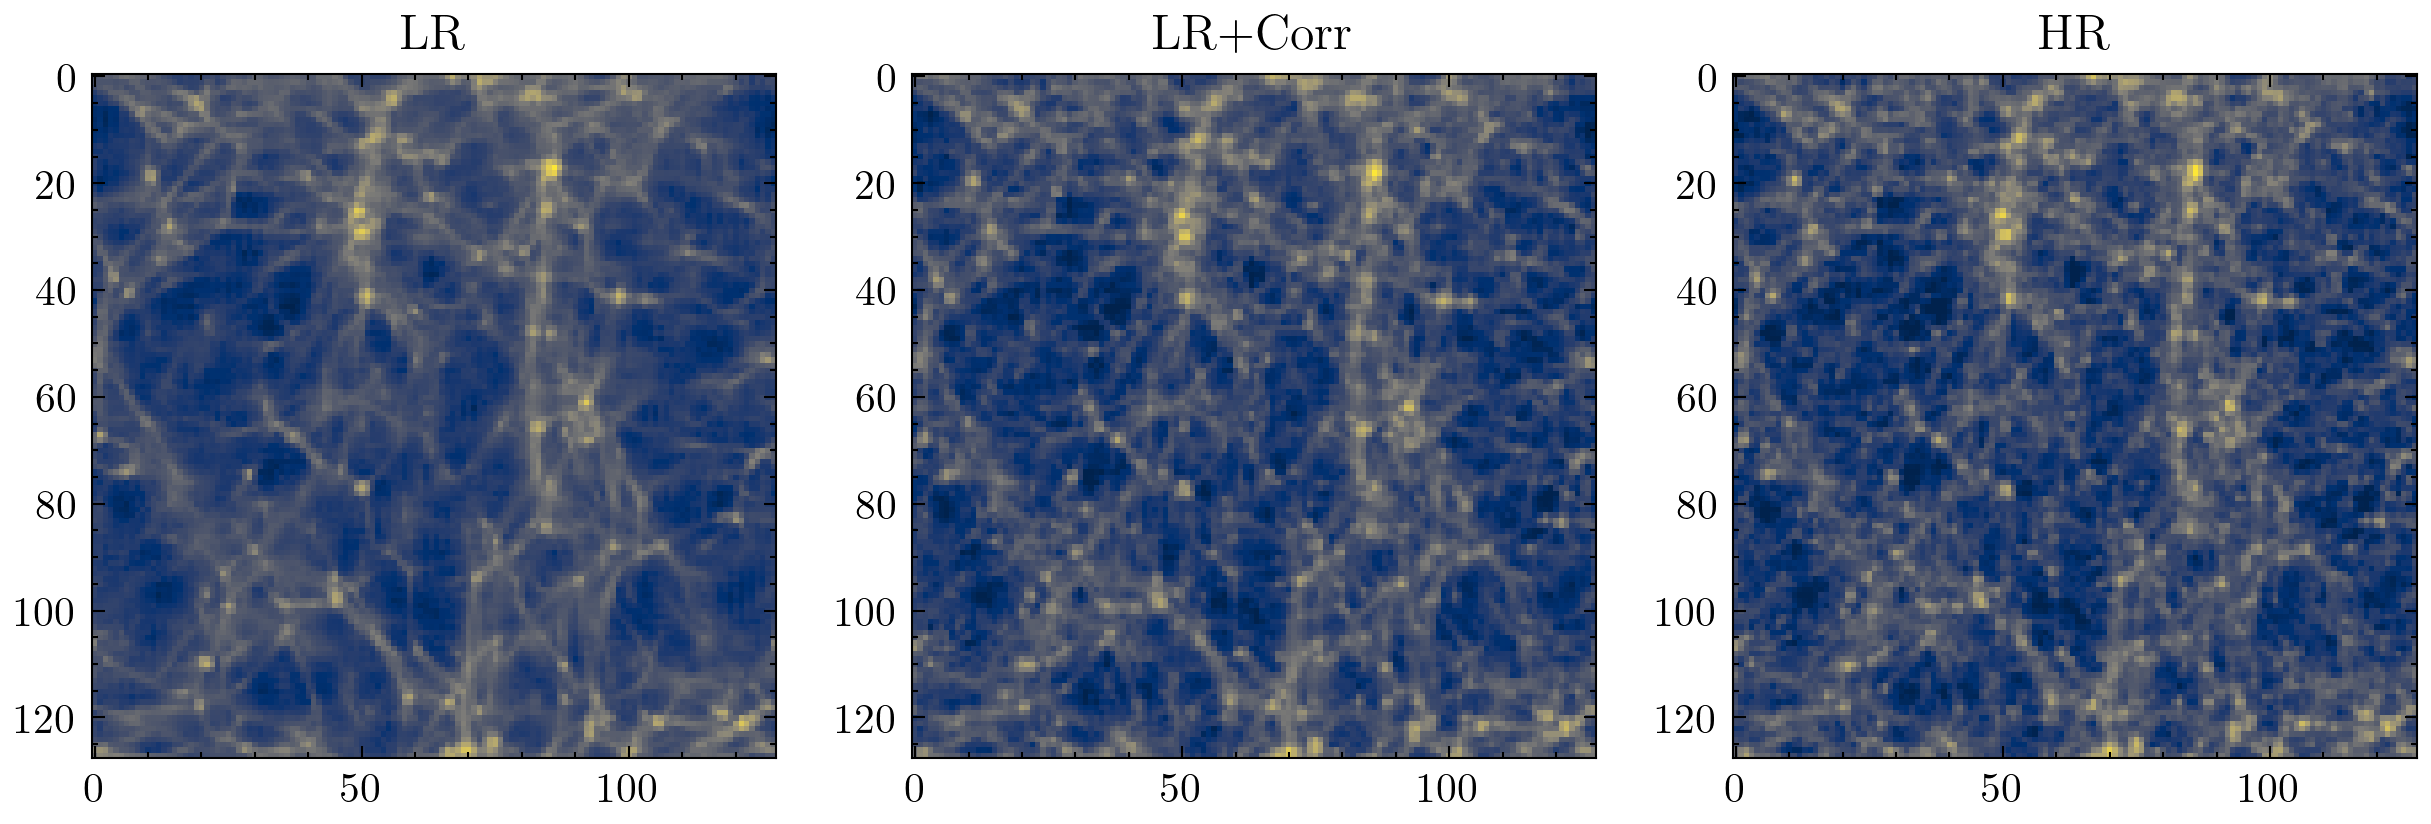

In [15]:

mesh_plot = mesh_hr
norm = LogNorm()#(vmin=0, vmax=150) 
cmap = 'cividis'

delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[2].imshow((delta_hr[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("LR+Corr")
ax[2].set_title("HR")

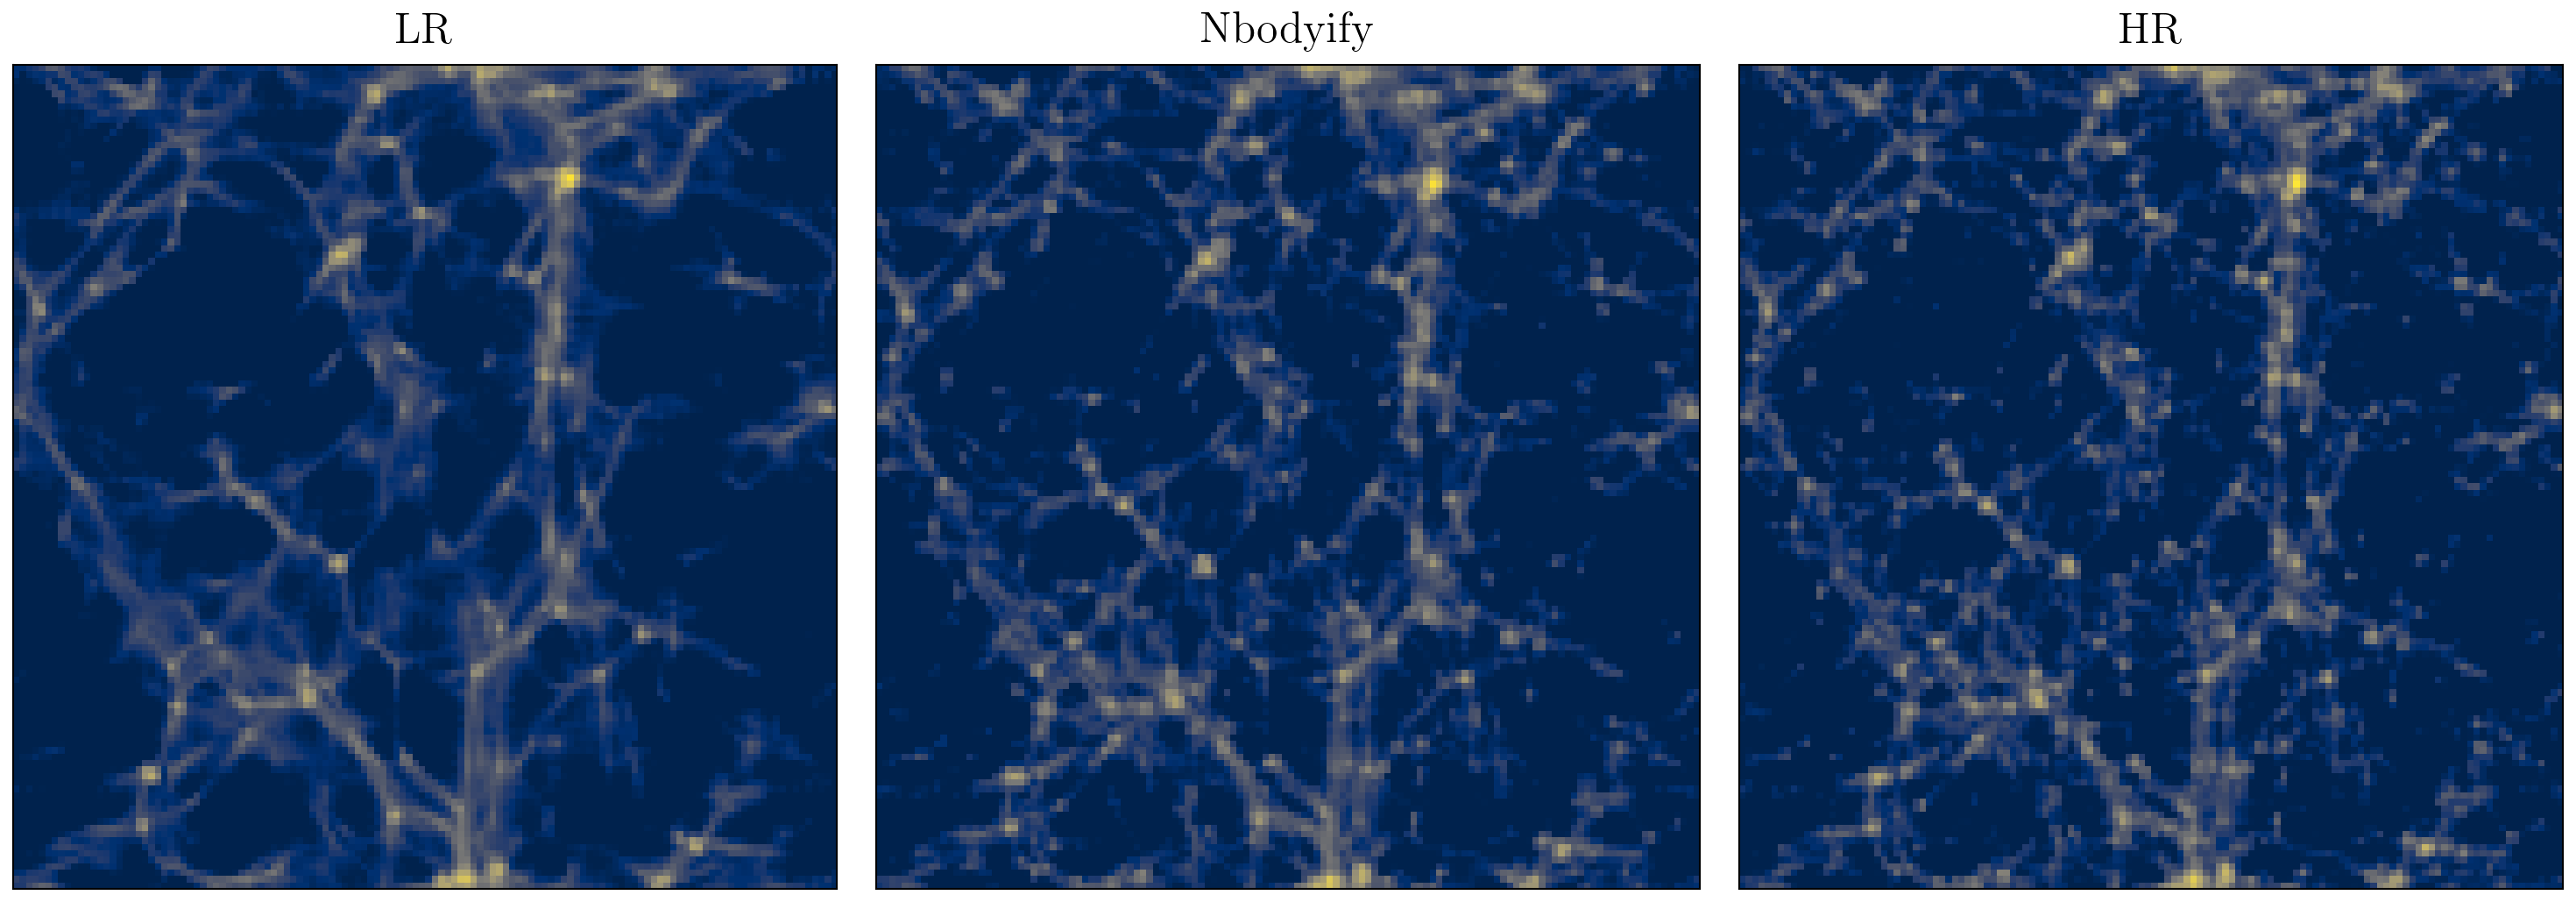

In [16]:


fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow((delta_lr[:60,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred[:60,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[2].imshow((delta_hr[:60,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

for a in ax:
    a.set_xticks([])  # Remove x-ticks and labels
    a.set_yticks([]) 
ax[0].set_title("LR")
ax[1].set_title("Nbodyify")
ax[2].set_title("HR")
plt.tight_layout()
plt.savefig('figures/png/densities.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/densities.pdf', bbox_inches="tight")

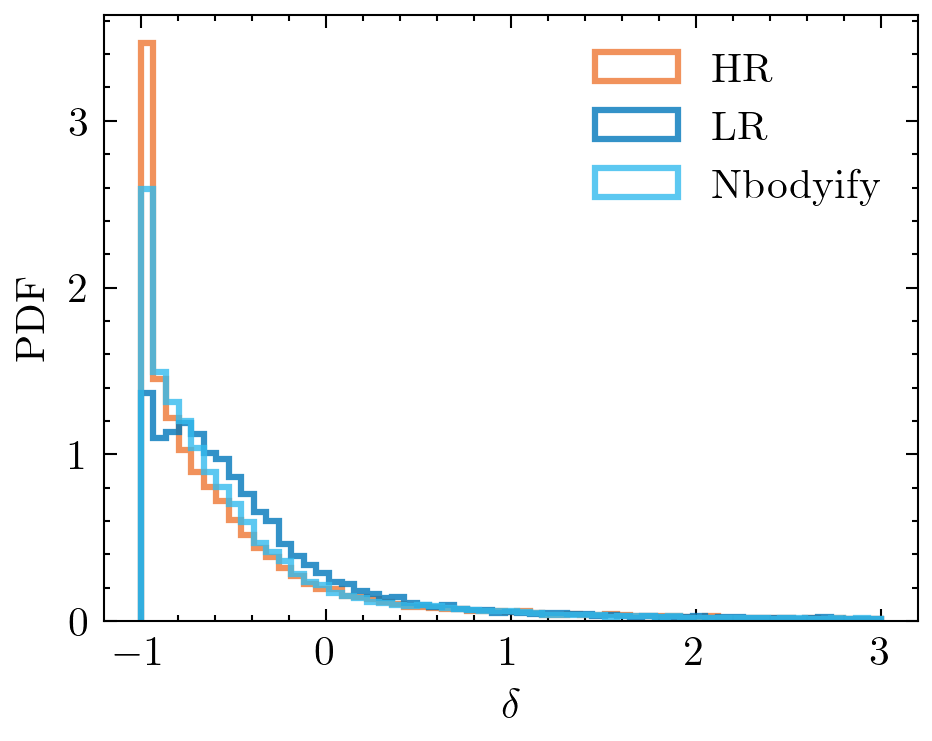

In [17]:
if data_config['mesh_lr'] == 32:
    skip = 2
elif data_config['mesh_lr'] == 64:
    skip = 4
_ = plt.hist(delta_hr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5)
_ = plt.hist(delta_lr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5)
_ = plt.hist(delta_pred[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,3,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')
plt.savefig('figures/png/density_histogram.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/density_histogram.pdf', bbox_inches="tight")

Text(0, 0.5, 'PDF')

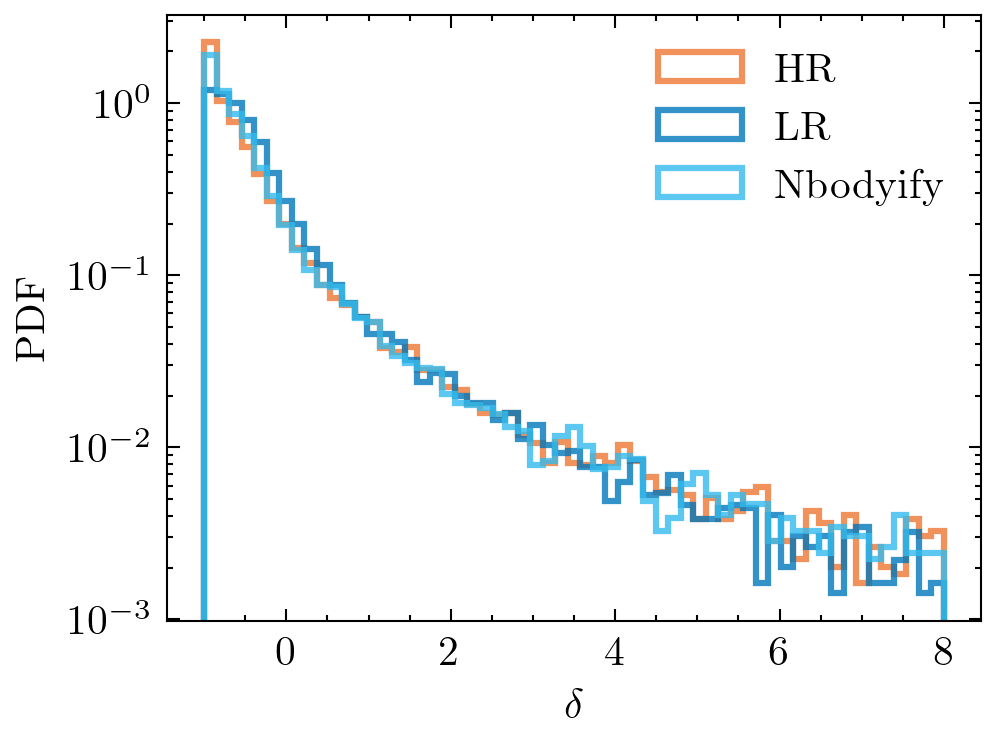

In [18]:
_ = plt.hist(delta_hr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='HR', histtype='step', linewidth=1.5, log=True,)
_ = plt.hist(delta_lr[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='LR',histtype='step', linewidth=1.5, log=True)
_ = plt.hist(delta_pred[::skip,::skip,::skip].reshape(-1)-1., bins=np.linspace(-1.,8,60),alpha=0.8, density=True, label='Nbodyify', histtype='step', linewidth=1.5, log=True,)
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'PDF')

In [19]:
k, pk_lr = power_spectrum(
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_pred = power_spectrum(
      compensate_cic(delta_pred),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_hr = power_spectrum(
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


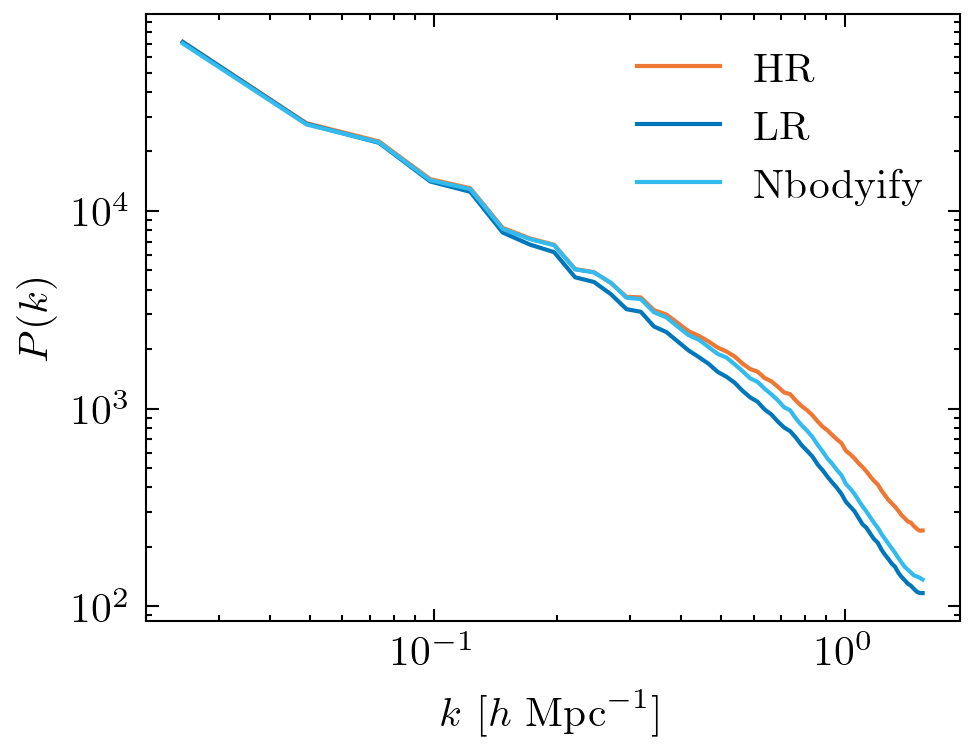

In [20]:
plt.loglog(k,pk_hr, label='HR')
c_lr = plt.loglog(k,pk_lr, label='LR')
c_pred = plt.loglog(k,pk_pred, label='Nbodyify')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.savefig('figures/png/pk_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/pk_z0.pdf', bbox_inches="tight")

Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

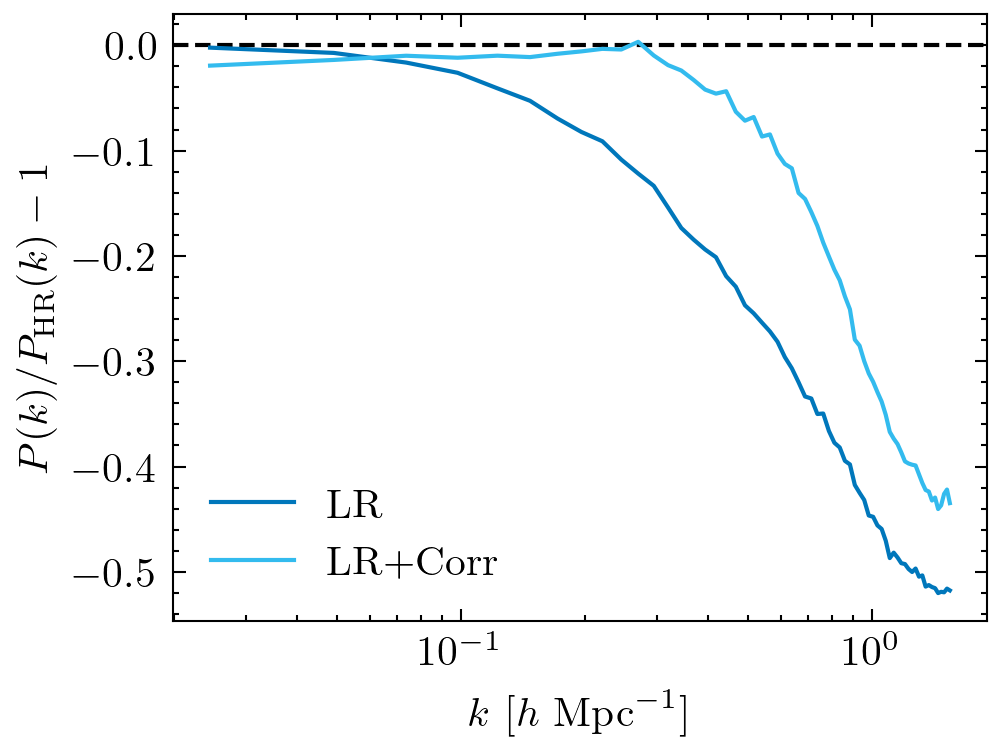

In [21]:
plt.axhline(y=0, linestyle='dashed', color='black')
plt.semilogx(k,pk_lr/pk_hr-1., label='LR', color=c_lr[0].get_color())
plt.semilogx(k,pk_pred/pk_hr-1., label='LR+Corr', color=c_pred[0].get_color())

plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")

In [22]:
k, cross_hr_hr = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)


k, cross_hr_lr = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, cross_hr_pred = cross_correlation_coefficients(
      compensate_cic(delta_hr),
      compensate_cic(delta_pred),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)



/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


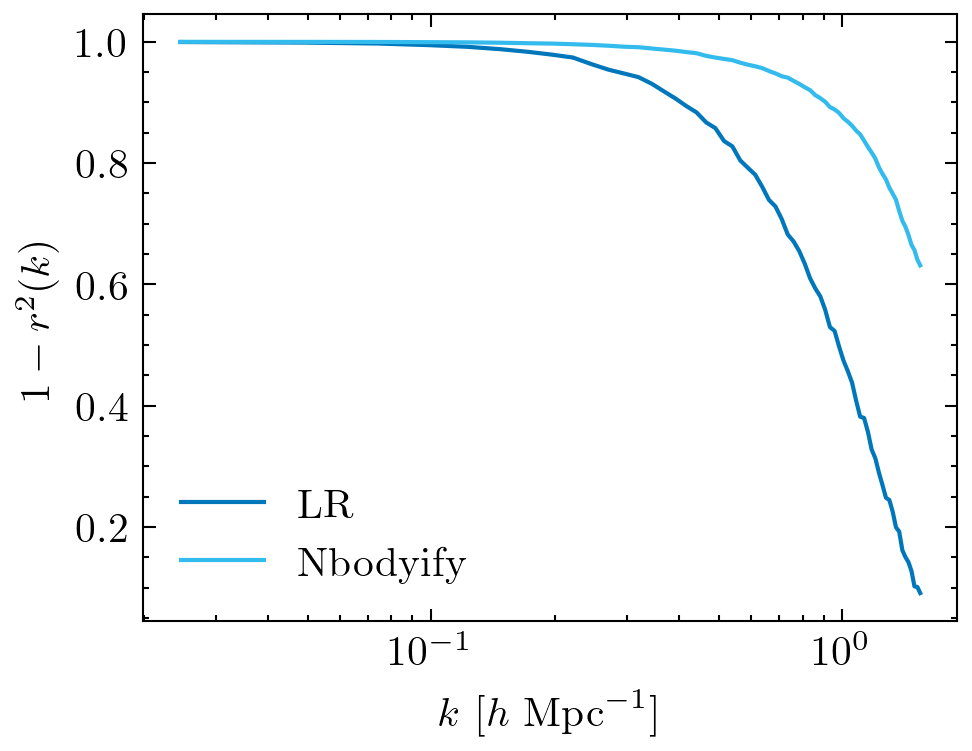

In [41]:
plt.semilogx(k, cross_hr_lr/np.sqrt(pk_hr)/np.sqrt(pk_lr), label='LR', color=c_lr[0].get_color())
plt.semilogx(k, cross_hr_pred/np.sqrt(pk_hr)/np.sqrt(pk_pred), label='Nbodyify', color=c_pred[0].get_color())
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$1 - r^2(k)$")
plt.legend()
plt.savefig('figures/png/r2_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/r2_z0.pdf', bbox_inches="tight")

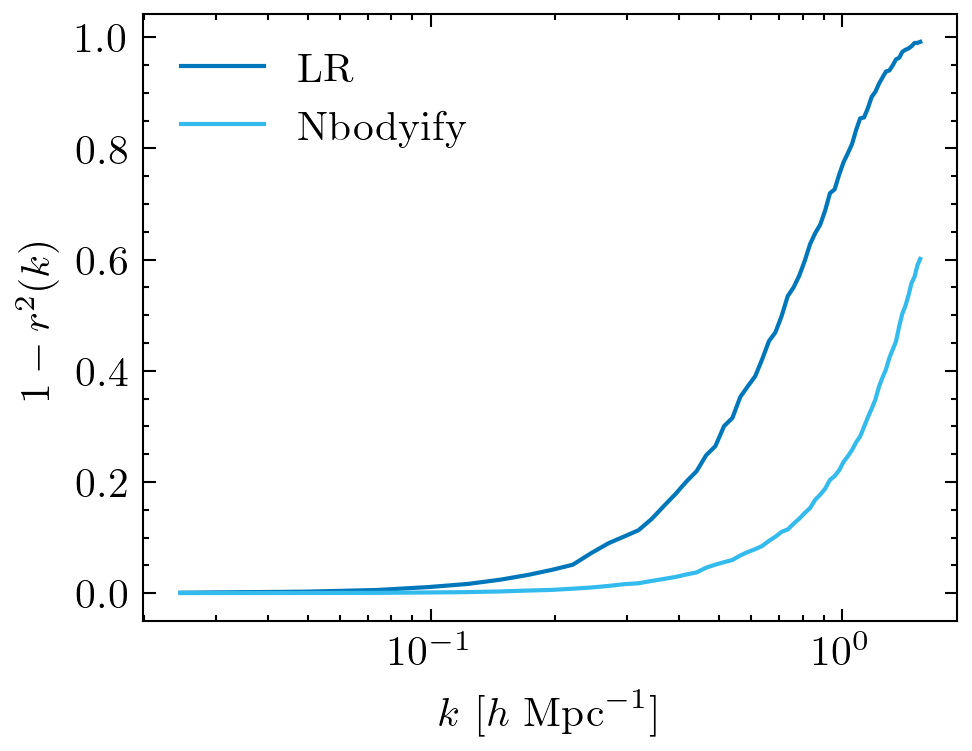

In [23]:
plt.semilogx(k, 1. - cross_hr_lr**2/pk_hr/pk_lr, label='LR', color=c_lr[0].get_color())
plt.semilogx(k, 1. - cross_hr_pred**2/pk_hr/pk_pred, label='Nbodyify', color=c_pred[0].get_color())
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$1 - r^2(k)$")
plt.legend()
plt.savefig('figures/png/r2_z0.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/r2_z0.pdf', bbox_inches="tight")

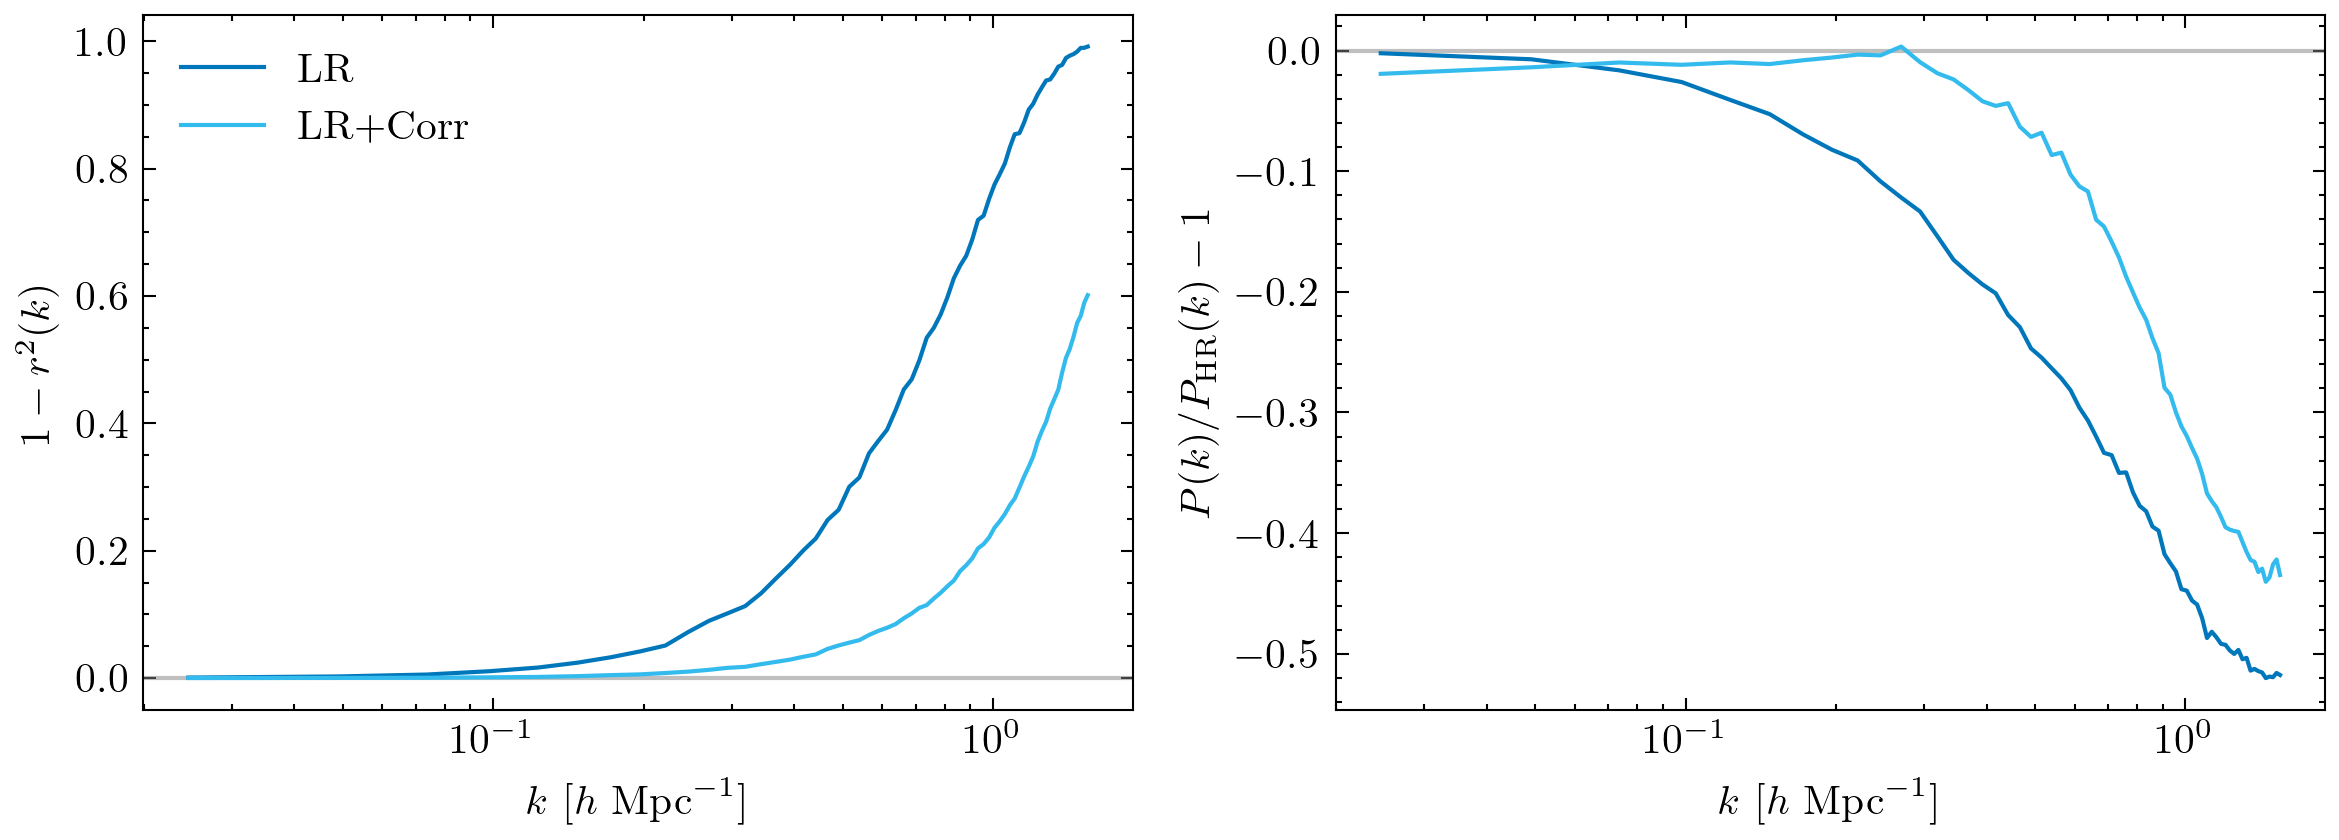

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].axhline(y=0, alpha=0.5, color='gray')
ax[1].axhline(y=0, alpha=0.5, color='gray')

ax[0].semilogx(k, 1. - cross_hr_lr**2/pk_hr/pk_lr, label='LR', color=c_lr[0].get_color())
ax[0].semilogx(k, 1. - cross_hr_pred**2/pk_hr/pk_pred, label='LR+Corr', color=c_pred[0].get_color())

ax[1].semilogx(k,pk_lr/pk_hr-1., label='LR', color=c_lr[0].get_color())
ax[1].semilogx(k,pk_pred/pk_hr-1., label='LR+Corr', color=c_pred[0].get_color())

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
ax[0].legend()
plt.tight_layout()

In [25]:
pk_hrs, pk_lrs, pk_preds = [], [], []
r_lrs_sq, r_preds_sq = [], []
for i, factor in enumerate(scale_factors):
    delta_hr = get_delta(data['hr'].positions[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_lr = get_delta(data['lr'].positions[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    delta_pred = get_delta(pos_pred[i]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
    k, pk_lr = power_spectrum(
        compensate_cic(delta_lr),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)

    k, pk_pred = power_spectrum(
        compensate_cic(delta_pred),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)

    k, pk_hr = power_spectrum(
        compensate_cic(delta_hr),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)
    k, cross_hr_lr = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_lr),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)

    k, cross_hr_pred = cross_correlation_coefficients(
        compensate_cic(delta_hr),
        compensate_cic(delta_pred),
        boxsize=np.array([256.] * 3),
        kmin=np.pi / 256.,
        dk=2 * np.pi / 256.)
    pk_hrs.append(pk_hr)
    pk_lrs.append(pk_lr)
    pk_preds.append(pk_pred)
    r_lrs_sq.append(cross_hr_lr**2 / pk_hr/ pk_lr)
    r_preds_sq.append(cross_hr_pred**2 / pk_hr/ pk_pred)

In [26]:
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter



/n/home11/ccuestalazaro/tmp/ipykernel_787908/2933318172.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

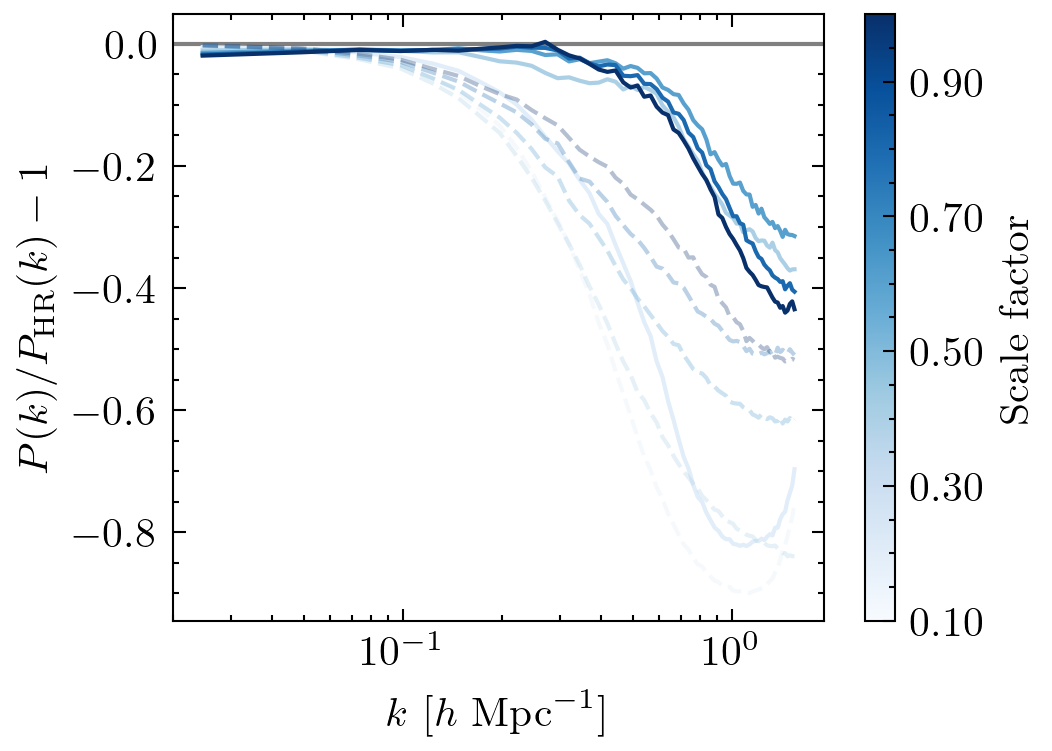

In [27]:
fig, ax = plt.subplots()

ax.axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax.semilogx(k, pk_preds[i]/pk_hrs[i] -1., color=color)
        ax.semilogx(k, pk_lrs[i]/pk_hrs[i] - 1., color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax.set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")


/n/home11/ccuestalazaro/tmp/ipykernel_787908/3212204088.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


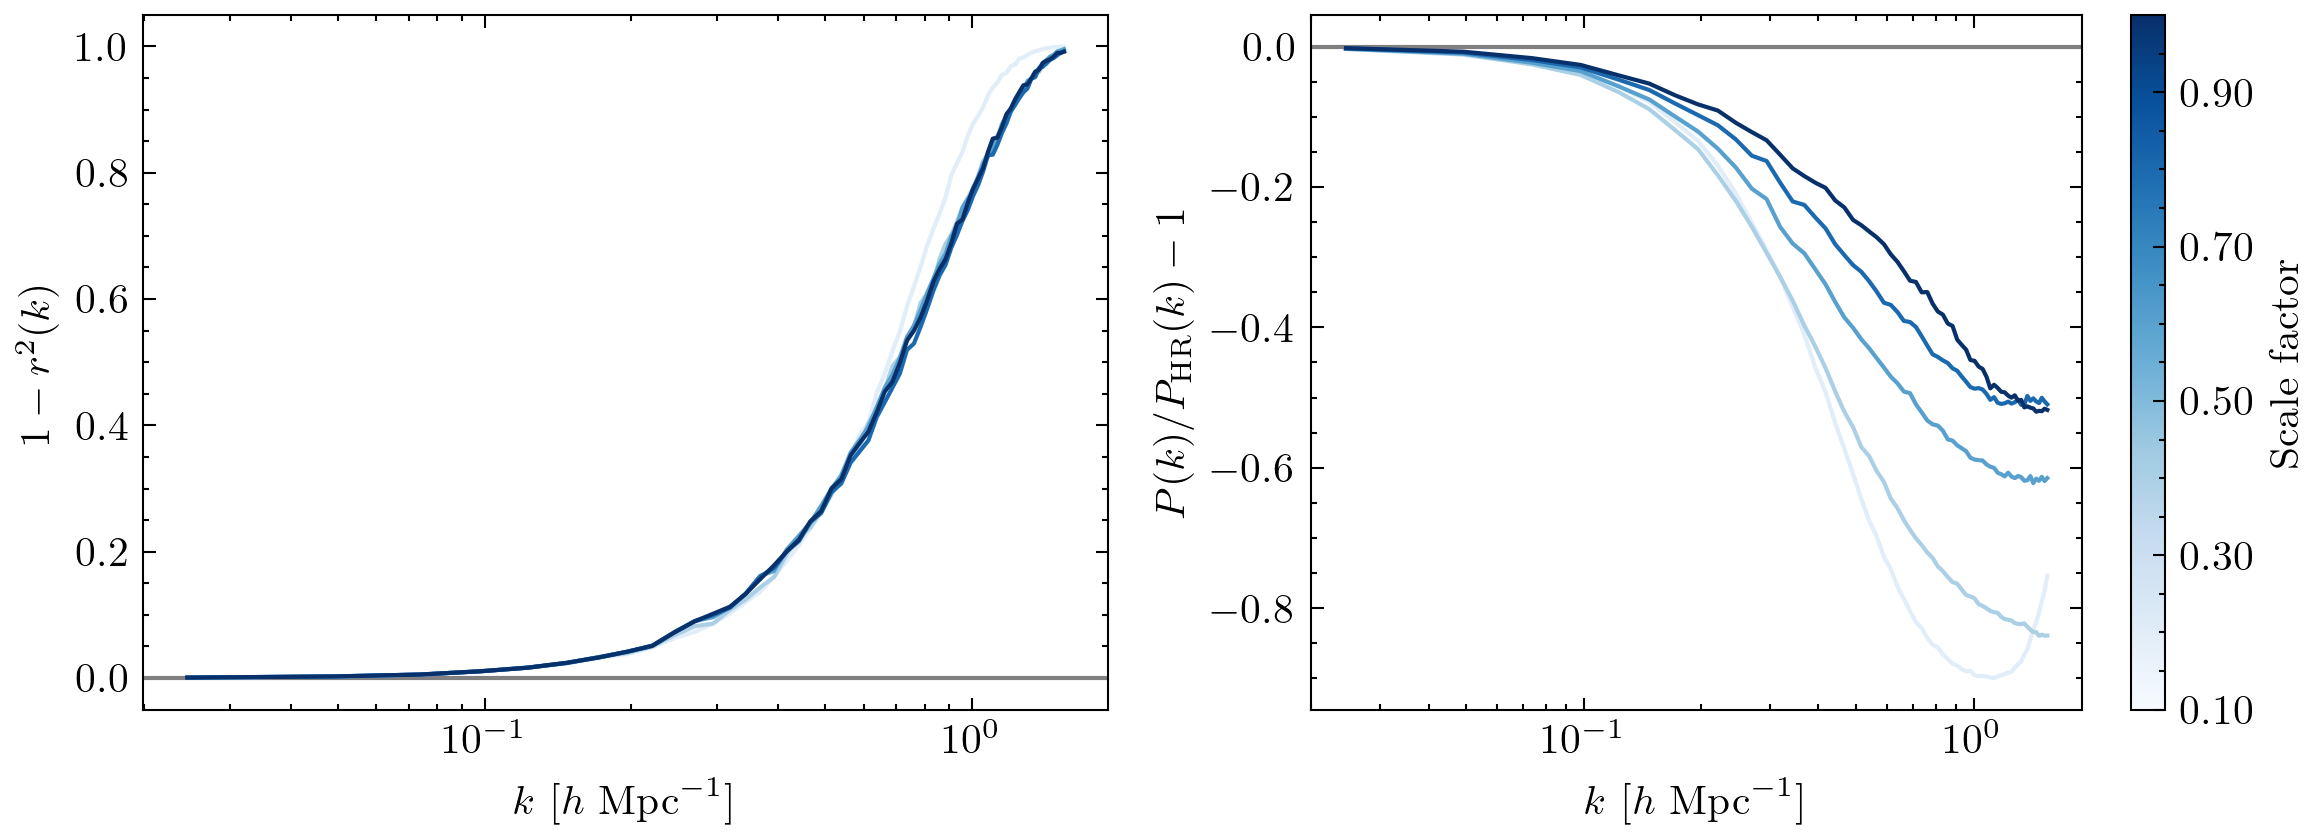

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=0, color='gray')
ax[1].axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i] -1., color=color)
        c = ax[0].semilogx(k, 1.-r_lrs_sq[i], color=color)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()

/n/home11/ccuestalazaro/tmp/ipykernel_787908/2383844706.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


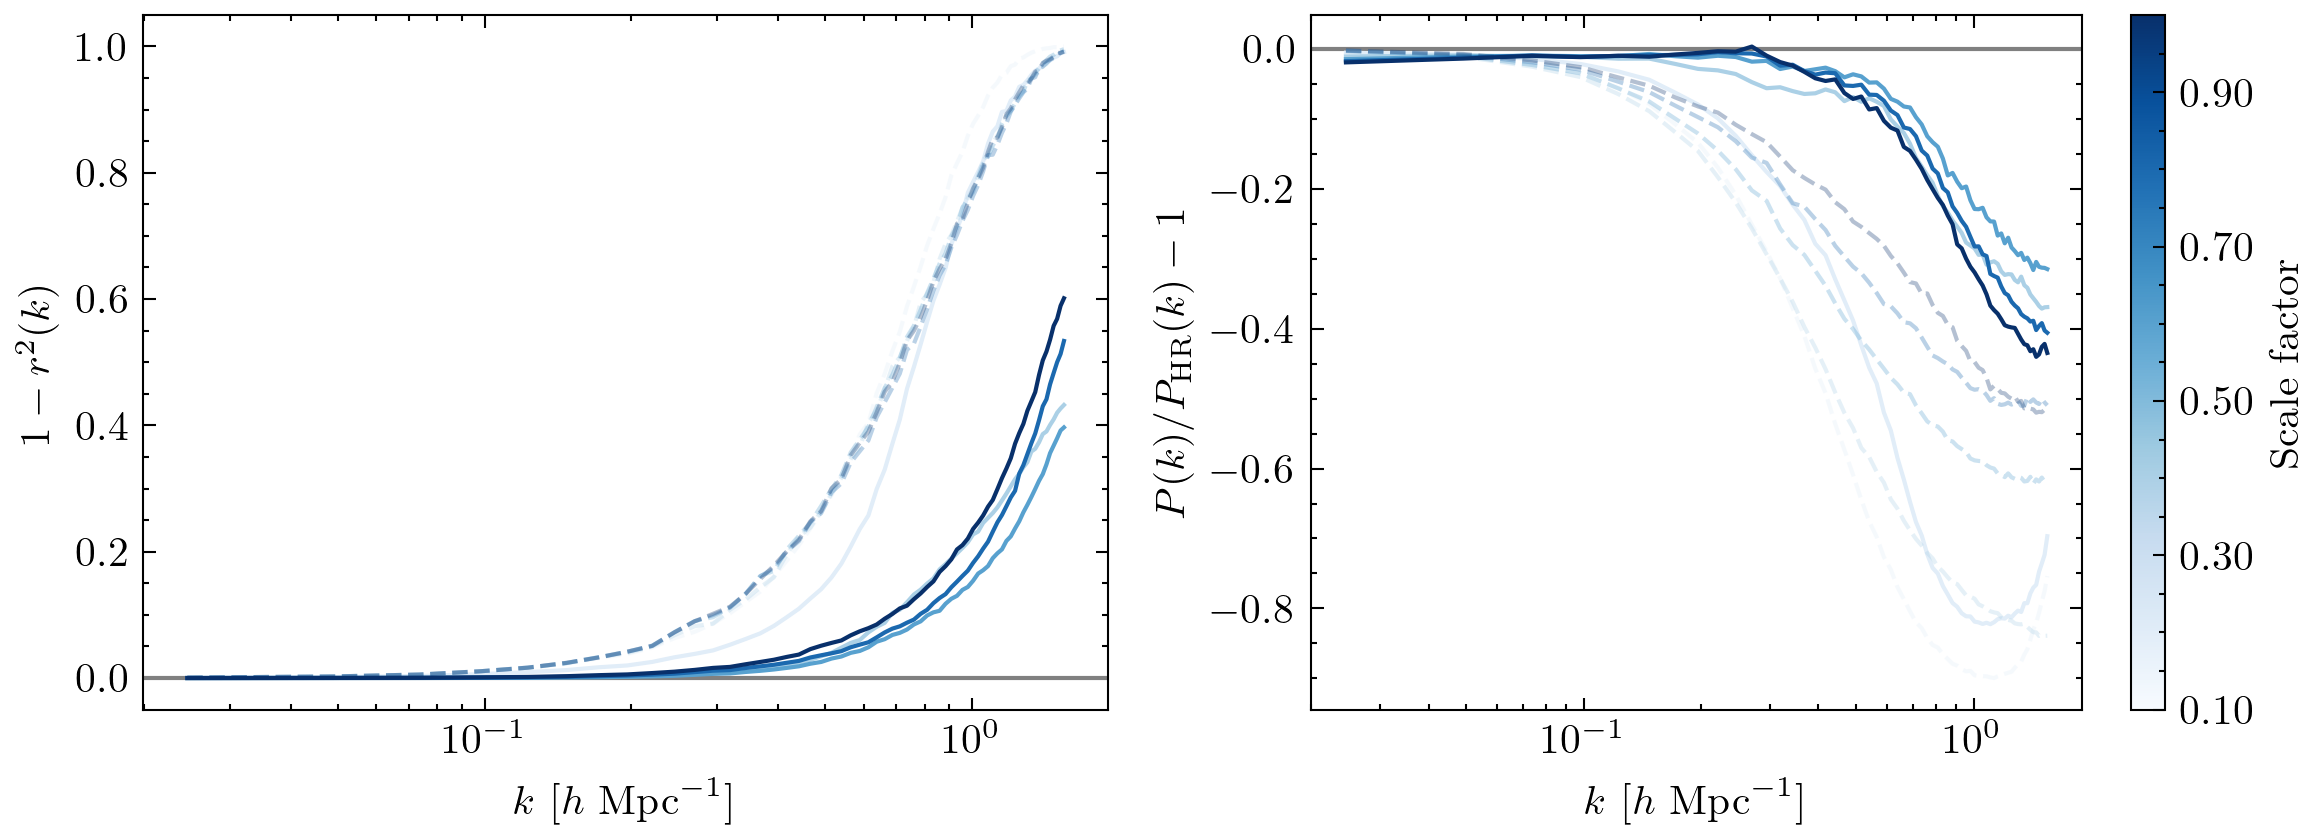

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].axhline(y=0, color='gray')
ax[1].axhline(y=0, color='gray')
min_idx = 0
colormap = cm.get_cmap('Blues')
norm = plt.Normalize(vmin=min(scale_factors[min_idx:]), vmax=max(scale_factors[min_idx:]))

for i, factor in enumerate(scale_factors):
    if i > min_idx and i%2:
        color = colormap(norm(factor))
        c = ax[1].semilogx(k, pk_preds[i]/pk_hrs[i] -1., color=color)
        ax[1].semilogx(k, pk_lrs[i]/pk_hrs[i] - 1., color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
        c = ax[0].semilogx(k, 1.-r_preds_sq[i], color=color)
        ax[0].semilogx(k, 1.-r_lrs_sq[i], color=c[0].get_color(), alpha=0.3, linestyle='dashed',)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], ticks=scale_factors[min_idx::2])
cbar.set_label('Scale factor')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[0].set_ylabel(r"$1 - r^2(k)$")
ax[1].set_ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")
plt.tight_layout()
plt.savefig('figures/png/redshit_evolution.png',dpi=600, bbox_inches="tight")
plt.savefig('figures/pdf/redshift_evolution.pdf', bbox_inches="tight")

In [30]:
# Get gravatational potentials and overdensities (at redshift 0)
from loss import get_gravitational_potential

In [31]:
_, pot_hr = get_gravitational_potential(data['hr'].positions[-1]*mesh_hr, n_mesh=mesh_hr)
_, pot_lr = get_gravitational_potential(data['lr'].positions[-1]*mesh_hr, n_mesh=mesh_hr)

In [32]:

_, pot_pred = get_gravitational_potential(pos_pred[-1]*mesh_hr, n_mesh=mesh_hr)

In [33]:
from jaxpm.painting import cic_paint, cic_read
from scipy.stats import binned_statistic


In [34]:
# read overdensity values at position
dens_hr = cic_read(delta_hr, data['hr'].positions[-1]*mesh_hr)

In [35]:
# correction:
pot_corr = pot_pred - pot_lr

In [36]:
density_bins = np.linspace(np.min(dens_hr), 40., 80)
bin_means, bin_edges, binnumber = binned_statistic(dens_hr, pot_corr, statistic='mean', bins=density_bins)
lr_bin_means, bin_edges, binnumber = binned_statistic(dens_hr, pot_lr, statistic='mean', bins=density_bins)


Text(0.5, 0, '$\\delta$')

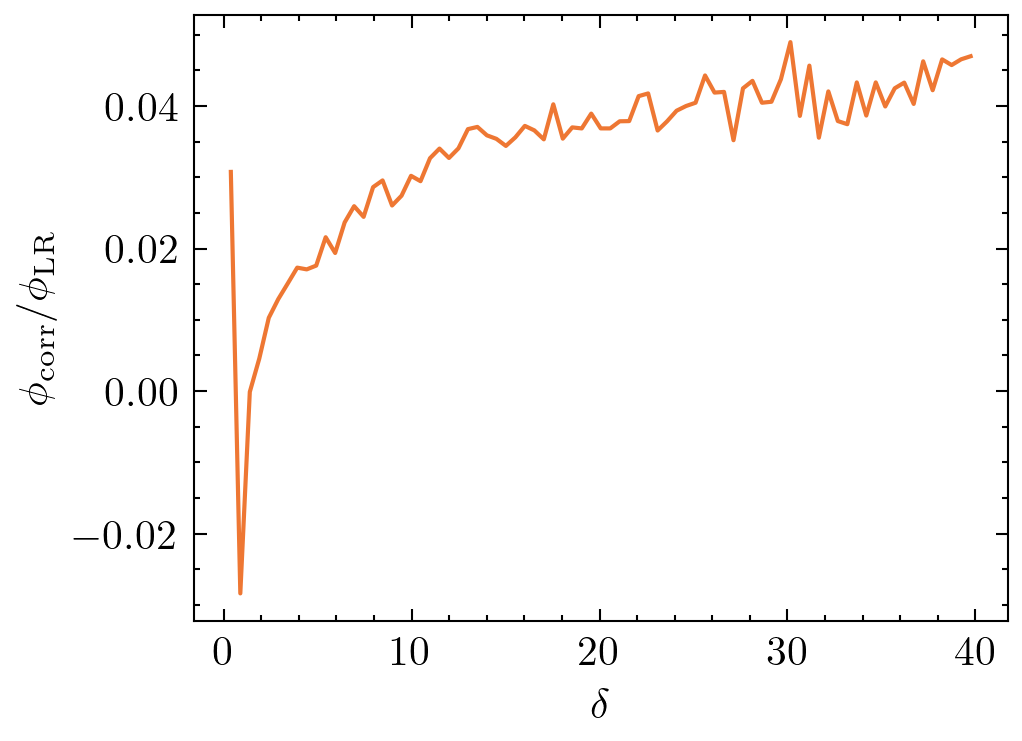

In [37]:
plt.plot( (bin_edges[1:] + bin_edges[:-1])/2., bin_means/lr_bin_means)
plt.ylabel(r'$\phi_\mathrm{corr}/\phi_\mathrm{LR}$')
plt.xlabel(r'$\delta$')

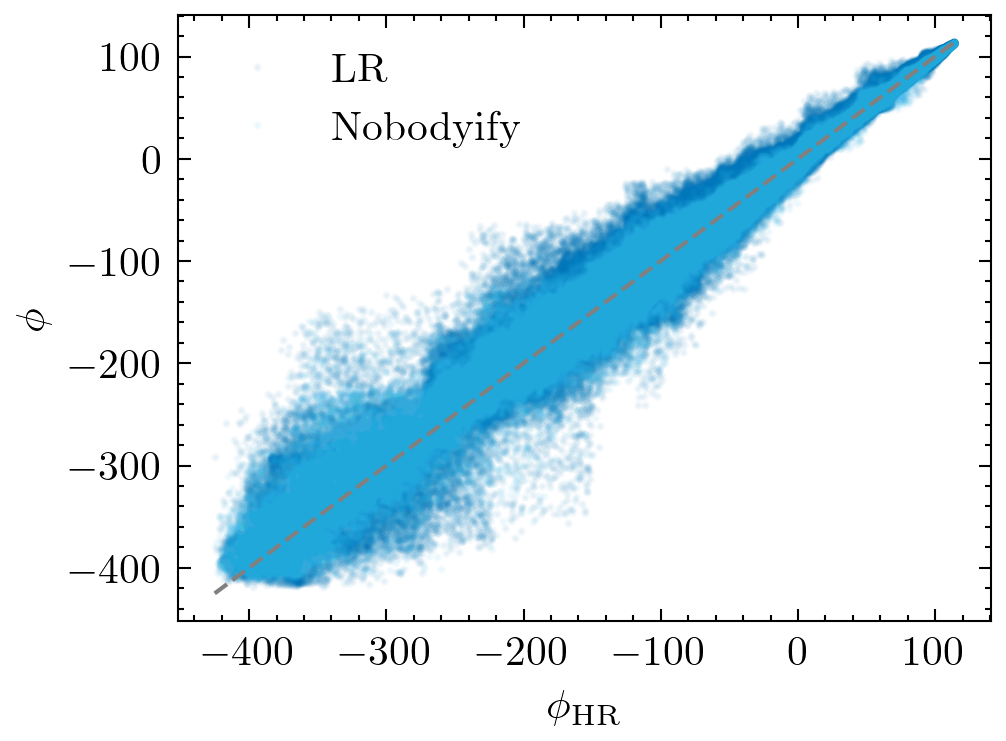

In [38]:
plt.plot(
    pot_hr,
    pot_lr,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='LR',
    color=c_lr[0].get_color(),
)
plt.plot(
    pot_hr,
    pot_pred,
    alpha=0.05,
    linestyle='',
    marker='o', 
    markersize=1,
    label='Nobodyify',
    color=c_pred[0].get_color(),
)
plt.plot(
    [np.min(pot_hr), np.max(pot_hr)],
    [np.min(pot_hr), np.max(pot_hr)],
    color='gray',
    linestyle='dashed',
)
plt.xlabel(r'$\phi_\mathrm{HR}$')
plt.ylabel(r'$\phi$')
plt.legend()
